# 基于LightGBM模型的房产租金预测

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
path1 = 'C:/AIfuturelab/af2019-ehouse-data/af2019-ehouse-training/'
path2 = 'C:/AIfuturelab/af2019-ehouse-data/af2019-ehouse-test-a/'
train = pd.read_csv(path1+'train_data_lgb.csv')
test = pd.read_csv(path2 + 'test_a_lgb.csv')

In [27]:
train['tradeTime'] = pd.to_datetime(train['tradeTime'])
train['month']=train['tradeTime'].dt.month

In [28]:
test['tradeTime'] = pd.to_datetime(test['tradeTime'])
test['month']=test['tradeTime'].dt.month

In [29]:
train.shape

(39792, 53)

In [30]:
test.shape

(2469, 52)

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39792 entries, 0 to 39791
Data columns (total 53 columns):
ID                    39792 non-null int64
area                  39792 non-null float64
rentType              39792 non-null object
houseType             39792 non-null object
houseFloor            39792 non-null object
totalFloor            39792 non-null int64
houseToward           39792 non-null object
houseDecoration       39792 non-null object
communityName         39792 non-null object
city                  39792 non-null object
region                39792 non-null object
plate                 39792 non-null object
buildYear             39792 non-null object
saleSecHouseNum       39792 non-null int64
subwayStationNum      39792 non-null int64
busStationNum         39792 non-null int64
interSchoolNum        39792 non-null int64
schoolNum             39792 non-null int64
privateSchoolNum      39792 non-null int64
hospitalNum           39792 non-null int64
drugStoreNum       

## -------------【租赁房源】特征处理-----------------

In [32]:
def get_room(x):
    return x.split("室")[0]

def get_hall(x):
    return x.split("室")[1].split("厅")[0]

def get_bathroom(x):
    return x.split("室")[1].split("厅")[1].split('卫')[0]

def get_houseType(roomNum):
    if roomNum=='1':
        return 'oneRoom_house'
    elif roomNum=='2':
        return 'twoRoom_house'
    elif roomNum=='3':
        return 'threeRoom_house'
    elif roomNum=='4':
        return 'fourRoom_house'
    elif roomNum=='5':
        return 'fiveRoom_house'
    elif roomNum=='6':
        return 'sixRoom_house'
    else:
        return 'MthsixRoom_house'

def map_houseToward(x):
    if x == '暂无数据':
        return 'noInfo'
    if x == '南':
        return 'south'
    else:
        return 'notSouth' 

In [33]:
#【租赁房源】特征处理
house_features=[
    'ID','area','communityName','month','rentType','houseType','totalFloor','houseToward','houseDecoration','houseFloor'
]

In [34]:
def get_house_features(_df,house_features):
    data = _df[house_features].copy()

    data['rentType'] = data['rentType'].replace(('--'),'unknown_type')
    data['rentType'] = data['rentType'].replace(('未知方式'),'unknown_type')
    data['rentType'] = data['rentType'].replace('整租','solo_rent')
    data['rentType'] = data['rentType'].replace('合租','co_rent')
    
    data['house_roomNum'] =data['houseType'].map(lambda x: get_room(x)).astype(int)
    data['house_hallNum']=data['houseType'].map(lambda x: get_hall(x)).astype(int)
    data['house_bathroomNum'] = data['houseType'].map(lambda x: get_bathroom(x)).astype(int)
    
    del data['houseType']
    
    # 楼层
    floor = {'低':0.3333, '中':0.6666, '高':1}
    data['Floorrate'] = data['houseFloor'].map(floor)
    data['Floor'] = data['totalFloor']*data['Floorrate']
    
    data.loc[:,'houseToward']=data['houseToward'].map(lambda x: map_houseToward(x))

    # 面积
    tmp = data.groupby(['communityName'],as_index=False)['area'].agg({'area_c_mean':'mean'})
    data = data.merge(tmp, on=['communityName'],how= 'left')  
    
    del data['Floorrate'],data['communityName'],data['month']
    
    return data

,ID,area,rentType,totalFloor,houseToward,houseDecoration,houseFloor,house_roomNum,house_hallNum,house_bathroomNum,Floor,area_c_mean
0,100309852,68.06,unknown_type,16,noInfo,其他,低,2,1,1,5.3328,47.132000
1,100307942,125.55,unknown_type,14,noInfo,简装,中,3,2,2,9.3324,102.904000
2,100307764,132.00,unknown_type,32,noInfo,其他,低,3,2,2,10.6656,114.084000
3,100306518,57.00,unknown_type,17,noInfo,精装,中,1,1,1,11.3322,58.931034
4,100305262,129.00,unknown_type,2,noInfo,毛坯,低,3,2,3,0.6666,92.567857


In [35]:
# housefeatures_df.info()

## ---------【配套设施】+【小区信息】特征处理-----------

In [36]:
def get_ageofhouse(buildYear):
    if buildYear == '暂无信息':
        return 'unkown'
    else:
        years = 2018-int(buildYear)
        if years <20:
            return 'within 20 years'
        elif years<40:
            return 'between 20 to 40 years'
        else:
            return 'older than 40 years'

In [37]:
facilities_features = ['ID',
       'communityName', 'region',
       'plate', 'buildYear', 'saleSecHouseNum',
       'subwayStationNum','plate_communityNum',
       'busStationNum', 'interSchoolNum', 'schoolNum', 'privateSchoolNum',
       'hospitalNum', 'drugStoreNum', 'gymNum', 'bankNum', 'shopNum',
       'parkNum', 'mallNum', 'superMarketNum'
]

In [ ]:
# 设备
def get_facilities_community_features(_df,facilities_features):
    data = _df[facilities_features].copy()
    
    data['com_buildYear'] = data['buildYear'].map(lambda x: get_ageofhouse(x))

    data['com_transportStation'] = (data['subwayStationNum'] + data['busStationNum'])/data['plate_communityNum']
    data['com_shoolNum'] = (data['interSchoolNum']+data['schoolNum']+data['privateSchoolNum'])/data['plate_communityNum']
    data['com_lifeNum'] = (data['hospitalNum']+data['drugStoreNum']+data['shopNum']+data['mallNum']+data['superMarketNum']+data['gymNum'] + data['parkNum']+data['bankNum'])/data['plate_communityNum']
    
    data = data.drop([ 'plate','communityName','region','buildYear','subwayStationNum','busStationNum','interSchoolNum','schoolNum','privateSchoolNum','hospitalNum','drugStoreNum','gymNum','bankNum','shopNum','parkNum', 'mallNum', 'superMarketNum','plate_communityNum'],axis=1).copy()
    return data

## -----------【板块】特征处理 -----------

In [39]:
#【版块特征】
plate_features=[
 'ID',
 'plate',
 'region',
 'month',
 'totalTradeMoney',
 'totalTradeArea',
 'tradeMeanPrice',
 'tradeSecNum',
 'totalNewTradeMoney',
 'totalNewTradeArea',
 'tradeNewMeanPrice',
 'tradeNewNum',
 'remainNewNum',
 'supplyNewNum',
 'supplyLandNum',
 'supplyLandArea',
 'tradeLandNum',
 'tradeLandArea',
 'landTotalPrice',
 'landMeanPrice',
 'totalWorkers',
 'newWorkers',
 'residentPopulation',
 'tradeTime'
]


In [ ]:
def get_plate_features(df_,plate):
    data=df_[plate].copy()
    
    tmp = data.groupby(['plate'], as_index=False)['tradeSecNum'].agg({'SecNum_p_max': 'max','SecNum_p_mean' : 'mean'})                                                                    
    data = data.merge(tmp, on=['plate'], how='left')
    tmp = data.groupby(['month'], as_index=False)['tradeSecNum'].agg({'SecNum_m_mean': 'mean'})                                                                                                                                   
    data = data.merge(tmp, on=['month'], how='left')
    tmp = data.groupby(['plate'], as_index=False)['tradeNewNum'].agg({ 'NewNum_p_max': 'max','NewNum_p_mean': 'mean'})                                                                    
    data = data.merge(tmp, on=['plate'], how='left')
    tmp = data.groupby(['plate'],as_index=False)['tradeMeanPrice'].agg({'SecmeanPrice_p_mean':'mean'})
    data = data.merge(tmp, on=['plate'], how='left')
    tmp = data.groupby(['plate'],as_index=False)['tradeNewMeanPrice'].agg({'NewmeanPrice_p_mean':'mean'}) 
    data = data.merge(tmp, on=['plate'], how='left')
    
    tmp = data.groupby(['region','month'],as_index=False)['tradeMeanPrice'].agg({'SecmeanPrice_rm_mean':'mean'})
    data = data.merge(tmp, on=['region','month'], how='left')
    tmp = data.groupby(['region','month'],as_index=False)['tradeNewMeanPrice'].agg({'NewmeanPrice_rm_mean':'mean'}) 
    data = data.merge(tmp, on=['region','month'], how='left')
    tmp = data.groupby(['region'],as_index=False)['tradeMeanPrice'].agg({'SecmeanPrice_r_mean':'mean'})
    data = data.merge(tmp, on=['region'], how='left')
    tmp = data.groupby(['region'],as_index=False)['tradeNewMeanPrice'].agg({'NewmeanPrice_r_mean':'mean'}) 
    data = data.merge(tmp, on=['region'], how='left')
    
    data['remainrate'] = (data.remainNewNum+data.supplyNewNum)/(data.remainNewNum+data.supplyNewNum+data.tradeNewNum)
    data.fillna(0,inplace=True)
    
    data['workerrate'] = data.newWorkers/data.totalWorkers
    data = data.drop(['plate','region','supplyLandNum','tradeLandNum','tradeTime','totalTradeArea','totalNewTradeArea','totalTradeMoney','totalNewTradeMoney','remainNewNum','supplyNewNum', 'supplyLandArea','tradeLandArea','landTotalPrice','landMeanPrice','totalWorkers','newWorkers'],axis=1).copy()
    
    return data  

## ----------【客户】特征处理 ---------------

In [43]:
#【customs_features】
customs_features = ['ID','pv', 'uv', 'lookNum']

In [44]:
def get_customs_features(_df,customs_features):
    data = _df[customs_features].copy()
    data['pv/uv'] = data['pv'] / data['uv'] 
    data.fillna(-999,inplace=True)
    del data['pv'],data['uv']
    return data

In [53]:
def merge_train_test(df_):
    train = df_.copy()
    
    all_data = pd.concat([train,test],axis=0,sort=False)
    housefeatures_df = get_house_features(all_data,house_features)
    facilities_community_df=get_facilities_community_features(all_data,facilities_features)
    plate_df = get_plate_features(all_data,plate_features)
    customer_df = get_customs_features(all_data,customs_features)
    
    # 连接
    all_data = all_data[['ID']]
    all_data = all_data.merge(housefeatures_df,how='left',on='ID')
    all_data = all_data.merge(facilities_community_df,how='left',on='ID')
    all_data = all_data.merge(plate_df,how='left',on='ID')
    all_data = all_data.merge(customer_df,how='left',on='ID')
    
    categorical_feats = ['rentType','houseToward','houseDecoration','houseFloor','com_buildYear']
    # 转换object类型数据
    for col in categorical_feats:
        all_data[col] = all_data[col].astype('category')

    train_df = train[['ID','tradeMoney']]
    train_df = train_df.merge(all_data,how='left',on='ID')
    test_df = test[['ID']]
    test_df = test_df.merge(all_data,how='left',on='ID')
    
    return train_df,test_df,categorical_feats

train_df,test_df,categorical_feats = merge_train_test(train)

In [54]:
train_df.to_csv(path1+'train_lgb.csv',encoding='utf_8_sig',index=False,header=True)
test_df.to_csv(path2 +'test_lgb.csv',encoding='utf_8_sig',index=False,header=True)

In [55]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39792 entries, 0 to 39791
Data columns (total 39 columns):
ID                      39792 non-null int64
tradeMoney              39792 non-null int64
area                    39792 non-null float64
rentType                39792 non-null category
totalFloor              39792 non-null int64
houseToward             39792 non-null category
houseDecoration         39792 non-null category
houseFloor              39792 non-null category
house_roomNum           39792 non-null int32
house_hallNum           39792 non-null int32
house_bathroomNum       39792 non-null int32
Floor                   39792 non-null float64
area_c_mean             39792 non-null float64
saleSecHouseNum         39792 non-null int64
com_buildYear           39792 non-null category
com_transportStation    39792 non-null float64
com_shoolNum            39792 non-null float64
com_lifeNum             39792 non-null float64
month                   39792 non-null int64
tradeMean

In [51]:
test_df.shape

(2469, 38)

In [56]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score

target=train_df['tradeMoney']
features = [f for f in train_df.columns if f not in ['ID','tradeMoney']]

# 利用lgb模型预测
params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
    
         'num_leaves': 63,
         'learning_rate': 0.01,    
         'min_data_in_leaf': 30, 
         
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
    
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 666}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=666)
oof_lgb = np.zeros(len(train_df))
in_lgb_pred = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

def Rsquare(y_pre,y_val):
    score = 1-(np.sum((y_pre-np.asarray(y_val))**2)/np.sum((y_pre-np.mean(np.asarray(y_val)))**2))
    return score

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df,train_df['tradeMoney'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx],categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx],categorical_feature=categorical_feats)

    num_round = 10000
    
    gbm = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 200) 
    oof_lgb[val_idx] = gbm.predict(train_df.iloc[val_idx][features], num_iteration=gbm.best_iteration)
    
    valpre = gbm.predict(train_df.iloc[val_idx][features], num_iteration=gbm.best_iteration)# 验证集的预测值
    actuals = list(train_df.iloc[val_idx]['tradeMoney'])
    print("score = ", Rsquare(valpre, actuals))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = gbm.feature_importance() 
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    in_lgb_pred += gbm.predict(test_df[features], num_iteration=gbm.best_iteration) / folds.n_splits  # 预测取均值

print("CV Score: {:<8.5f}".format(r2_score(target, oof_lgb)))


C:\Users\liushihan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


fold 0


C:\Users\liushihan\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\liushihan\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 668.667	valid_1's rmse: 829.166
[2000]	training's rmse: 571.271	valid_1's rmse: 812.155
[3000]	training's rmse: 511.012	valid_1's rmse: 808.989
Early stopping, best iteration is:
[2974]	training's rmse: 512.3	valid_1's rmse: 808.851
score =  0.8839234524354683
fold 1


C:\Users\liushihan\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\liushihan\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 662.429	valid_1's rmse: 837.542
[2000]	training's rmse: 564.694	valid_1's rmse: 822.138
[3000]	training's rmse: 503.878	valid_1's rmse: 818.22
Early stopping, best iteration is:
[3435]	training's rmse: 483.16	valid_1's rmse: 817.617
score =  0.8846096320431318
fold 2


C:\Users\liushihan\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\liushihan\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 666.421	valid_1's rmse: 835.357
[2000]	training's rmse: 568.859	valid_1's rmse: 817.783
[3000]	training's rmse: 508.246	valid_1's rmse: 813.166
[4000]	training's rmse: 464.352	valid_1's rmse: 812.395
Early stopping, best iteration is:
[3876]	training's rmse: 469.259	valid_1's rmse: 812.255
score =  0.8809426697981197
fold 3


C:\Users\liushihan\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\liushihan\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 674.748	valid_1's rmse: 818.957
[2000]	training's rmse: 576.854	valid_1's rmse: 798.137
[3000]	training's rmse: 515.631	valid_1's rmse: 790.588
[4000]	training's rmse: 471.482	valid_1's rmse: 787.585
[5000]	training's rmse: 436.246	valid_1's rmse: 786.562
Early stopping, best iteration is:
[5740]	training's rmse: 414.223	valid_1's rmse: 786.165
score =  0.8858787106840438
fold 4


C:\Users\liushihan\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\liushihan\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 670.354	valid_1's rmse: 815.172
[2000]	training's rmse: 573.161	valid_1's rmse: 800.227
[3000]	training's rmse: 513.705	valid_1's rmse: 795.961
Early stopping, best iteration is:
[3727]	training's rmse: 480.173	valid_1's rmse: 794.967
score =  0.8837365346272043
CV Score: 0.89579 


In [37]:
# 储存预测结果
sub=test_df[['ID']]
sub['tradeMoney']=in_lgb_pred
sub.to_csv('C:/AIfuturelab/output/output_lgb.csv',encoding='utf_8_sig',index=False,header=True)

sub['tradeMoney'].describe()

C:\Users\liushihan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


count     2469.000000
mean      5446.359455
std       2064.514469
min       1952.145948
25%       4084.422503
50%       4840.025032
75%       6187.798982
max      14531.690042
Name: tradeMoney, dtype: float64

In [32]:
feature_importance_df

,Feature,importance,fold
0,area,45167,1
1,rentType,1661,1
2,totalFloor,20424,1
3,houseToward,2735,1
4,houseDecoration,3944,1
5,houseFloor,3128,1
6,house_roomNum,5840,1
7,house_hallNum,3263,1
8,house_bathroomNum,7928,1
9,Floor,18553,1


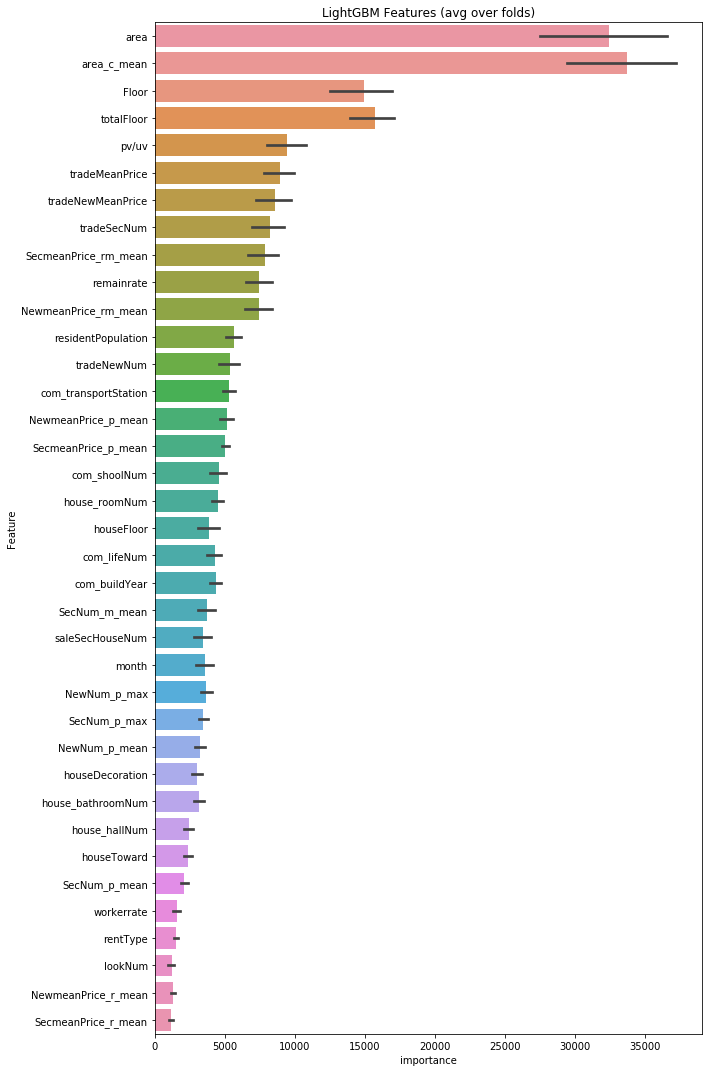

In [38]:
# 可视化特征的重要性
import seaborn as sns
import matplotlib.pyplot as plt

# 提取较重要的特征
cols = (feature_importance_df[["Feature", "importance"]].groupby("Feature").mean().sort_values(by="importance", ascending=False)[:500].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(10,15))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()